In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import random
import torch
import numpy as np
import pandas as pd
import multiprocessing
from itertools import islice

In [3]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import WandbLogger, CSVLogger

from estimator import LagGPTEstimator

In [4]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [5]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [6]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds, weights=[sum([len(x["target"]) for x in d]) for d in gluonts_ds])

In [7]:
val_dataset = get_dataset("m4_weekly").test

In [8]:
meta = get_dataset("m4_weekly").metadata

In [9]:
meta

MetaData(freq='W', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='359')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=13)

In [10]:
#set more seeds

In [12]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logger = CSVLogger("logs", name="Lag-gpt-large-"+str(seed))

In [15]:
!unset LD_LIBRARY_PATH

In [13]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 1024, 2048 
    batch_size=4, # 4, 8, 16, 32
    n_layer=8,
    n_head=4,
    n_embd=32, # 32,64,128,256,512,1024,2048,4096
    scaling="std",
    
    # set aug prob
    aug_prob=1.0,
    aug_rate=0.1,
    
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=300, accelerator="gpu", precision="32", logger=logger),
)

In [14]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/Lag-gpt-large-42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 232 K 
--------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached 8.11872 (best 8.11872), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 7.60269 (best 7.60269), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' reached 7.51226 (best 7.51226), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=3-step=400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' reached 7.49736 (best 7.49736), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=7-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' reached 7.41756 (best 7.41756), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=8-step=900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' reached 7.23044 (best 7.23044), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=10-step=1100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' reached 7.22555 (best 7.22555), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=12-step=1300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' reached 7.18844 (best 7.18844), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=14-step=1500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' reached 7.14321 (best 7.14321), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=17-step=1800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' reached 7.08194 (best 7.08194), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=18-step=1900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2800: 'val_loss' reached 7.07510 (best 7.07510), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=27-step=2800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' reached 7.06949 (best 7.06949), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=28-step=2900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' reached 7.06393 (best 7.06393), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=31-step=3200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' reached 7.00931 (best 7.00931), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=32-step=3300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' reached 6.95542 (best 6.95542), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=40-step=4100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 4600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' reached 6.89261 (best 6.89261), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=58-step=5900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' reached 6.88254 (best 6.88254), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=74-step=7500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 7600: 'val_loss' reached 6.84242 (best 6.84242), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=75-step=7600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' reached 6.82712 (best 6.82712), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=79-step=8000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' reached 6.81539 (best 6.81539), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=87-step=8800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 100, global step 10100: 'val_loss' reached 6.81418 (best 6.81418), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=100-step=10100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 101, global step 10200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 102, global step 10300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 103, global step 10400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 104, global step 10500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 105, global step 10600: 'val_loss' reached 6.81291 (best 6.81291), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=105-step=10600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 106, global step 10700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 107, global step 10800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 108, global step 10900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 109, global step 11000: 'val_loss' reached 6.75311 (best 6.75311), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=109-step=11000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 110, global step 11100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 111, global step 11200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 112, global step 11300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 113, global step 11400: 'val_loss' reached 6.73982 (best 6.73982), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=113-step=11400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 114, global step 11500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 115, global step 11600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 116, global step 11700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 117, global step 11800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 118, global step 11900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 119, global step 12000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 120, global step 12100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 121, global step 12200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 122, global step 12300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 123, global step 12400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 124, global step 12500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 125, global step 12600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 126, global step 12700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 127, global step 12800: 'val_loss' reached 6.73412 (best 6.73412), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=127-step=12800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 128, global step 12900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 129, global step 13000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 130, global step 13100: 'val_loss' reached 6.72889 (best 6.72889), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=130-step=13100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 131, global step 13200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 132, global step 13300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 133, global step 13400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 134, global step 13500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 135, global step 13600: 'val_loss' reached 6.71723 (best 6.71723), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=135-step=13600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 136, global step 13700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 137, global step 13800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 138, global step 13900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 139, global step 14000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 140, global step 14100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 141, global step 14200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 142, global step 14300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 143, global step 14400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 144, global step 14500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 145, global step 14600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 146, global step 14700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 147, global step 14800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 148, global step 14900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 149, global step 15000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 150, global step 15100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 151, global step 15200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 152, global step 15300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 153, global step 15400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 154, global step 15500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 155, global step 15600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 156, global step 15700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 157, global step 15800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 158, global step 15900: 'val_loss' reached 6.71222 (best 6.71222), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=158-step=15900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 159, global step 16000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 160, global step 16100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 161, global step 16200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 162, global step 16300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 163, global step 16400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 164, global step 16500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 165, global step 16600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 166, global step 16700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 167, global step 16800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 168, global step 16900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 169, global step 17000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 170, global step 17100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 171, global step 17200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 172, global step 17300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 173, global step 17400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 174, global step 17500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 175, global step 17600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 176, global step 17700: 'val_loss' reached 6.68843 (best 6.68843), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=176-step=17700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 177, global step 17800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 178, global step 17900: 'val_loss' reached 6.67346 (best 6.67346), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=178-step=17900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 179, global step 18000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 180, global step 18100: 'val_loss' reached 6.66641 (best 6.66641), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=180-step=18100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 181, global step 18200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 182, global step 18300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 183, global step 18400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 184, global step 18500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 185, global step 18600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 186, global step 18700: 'val_loss' reached 6.66348 (best 6.66348), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=186-step=18700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 187, global step 18800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 188, global step 18900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 189, global step 19000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 190, global step 19100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 191, global step 19200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 192, global step 19300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 193, global step 19400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 194, global step 19500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 195, global step 19600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 196, global step 19700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 197, global step 19800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 198, global step 19900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 199, global step 20000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 200, global step 20100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 201, global step 20200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 202, global step 20300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 203, global step 20400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 204, global step 20500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 205, global step 20600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 206, global step 20700: 'val_loss' reached 6.65971 (best 6.65971), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=206-step=20700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 207, global step 20800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 208, global step 20900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 209, global step 21000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 210, global step 21100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 211, global step 21200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 212, global step 21300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 213, global step 21400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 214, global step 21500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 215, global step 21600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 216, global step 21700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 217, global step 21800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 218, global step 21900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 219, global step 22000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 220, global step 22100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 221, global step 22200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 222, global step 22300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 223, global step 22400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 224, global step 22500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 225, global step 22600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 226, global step 22700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 227, global step 22800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 228, global step 22900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 229, global step 23000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 230, global step 23100: 'val_loss' reached 6.65895 (best 6.65895), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=230-step=23100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 231, global step 23200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 232, global step 23300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 233, global step 23400: 'val_loss' reached 6.65667 (best 6.65667), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=233-step=23400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 234, global step 23500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 235, global step 23600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 236, global step 23700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 237, global step 23800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 238, global step 23900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 239, global step 24000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 240, global step 24100: 'val_loss' reached 6.63798 (best 6.63798), saving model to 'logs/Lag-gpt-large-42/version_0/checkpoints/epoch=240-step=24100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 241, global step 24200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 242, global step 24300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 243, global step 24400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 244, global step 24500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 245, global step 24600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 246, global step 24700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 247, global step 24800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 248, global step 24900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 249, global step 25000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 250, global step 25100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 251, global step 25200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 252, global step 25300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 253, global step 25400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 254, global step 25500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 255, global step 25600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 256, global step 25700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 257, global step 25800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 258, global step 25900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 259, global step 26000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 260, global step 26100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 261, global step 26200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 262, global step 26300: 'val_loss' was not in top 1


In [10]:
test_dataset = get_dataset("traffic").test

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [19]:
forecasts = list(forecast_it)

In [20]:
tss = list(ts_it)

In [21]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)

Running evaluation: 100%|██████████| 359/359 [00:01<00:00, 335.34it/s]


In [22]:
agg_metrics

{'MSE': 9969612.113533027,
 'abs_error': 7366101.9279174805,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 28.42205827335383,
 'MAPE': 0.2988834578008296,
 'sMAPE': 0.2726626752296837,
 'MSIS': 849.5236802353385,
 'QuantileLoss[0.1]': 2619066.44274292,
 'Coverage[0.1]': 0.2607670880651382,
 'QuantileLoss[0.2]': 4025790.6657470707,
 'Coverage[0.2]': 0.2991214913220484,
 'QuantileLoss[0.3]': 5249250.0582702635,
 'Coverage[0.3]': 0.32247696593100494,
 'QuantileLoss[0.4]': 6357569.48656006,
 'Coverage[0.4]': 0.34368973644739664,
 'QuantileLoss[0.5]': 7366101.871582031,
 'Coverage[0.5]': 0.3642596957360188,
 'QuantileLoss[0.6]': 8281175.587304687,
 'Coverage[0.6]': 0.38054424683951144,
 'QuantileLoss[0.7]': 9059906.65803833,
 'Coverage[0.7]': 0.40047139490036426,
 'QuantileLoss[0.8]': 9669441.968884278,
 'Coverage[0.8]': 0.42725519605742457,
 'QuantileLoss[0.9]': 9953448.799456786,
 'Coverage[0.9]': 0.4683951146

In [23]:
metric_type = []
error = []
for state in agg_metrics:
    metric_type.append(state)
for value in agg_metrics.values():
    error.append(value)

In [24]:
df = pd.DataFrame( error, metric_type).reset_index().rename(columns = {'index': 'error',0:'metric_type'}).T
df.columns = df.iloc[0,:]
df = df.iloc[1:, :]
df['#parameters']=411000000#102000000#411000000#6800000
df['seed'] = seed
# df.to_csv('error100.csv')

In [25]:
dff = pd.read_csv('error100.csv')#.drop('Unnamed: 0', axis=1)
# dff.columns
dff = dff.append(df)
dff.to_csv('error100.csv', index=False)

/tmp/ipykernel_86/941960961.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df)


In [ ]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

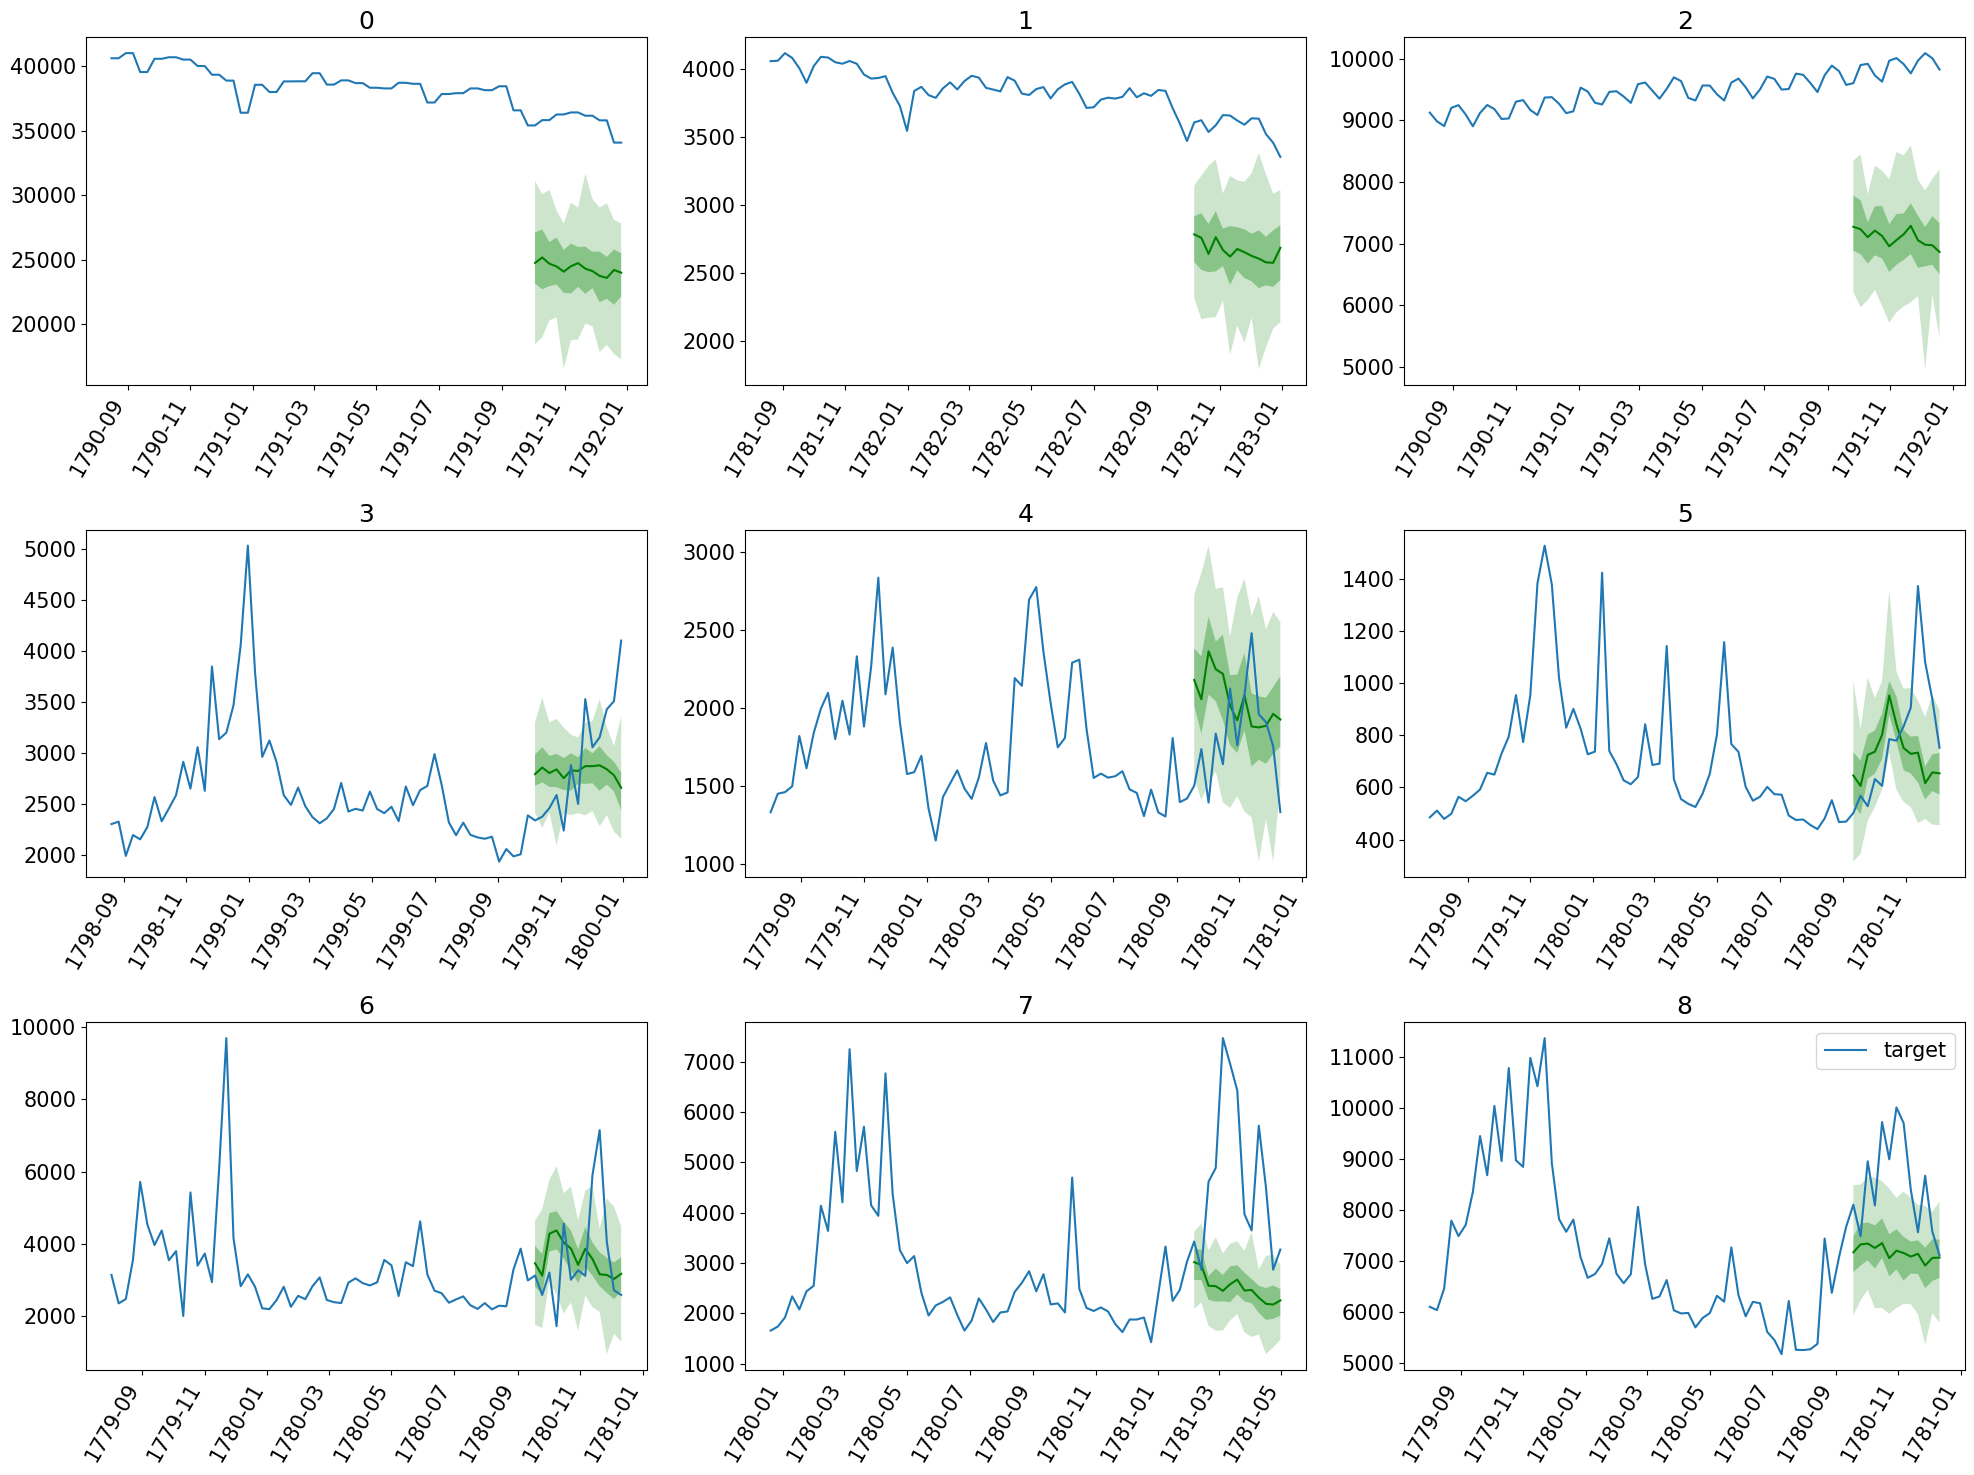

In [68]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [64]:
df = pd.read_csv('error100.csv')
df = df.drop_duplicates(subset=['#parameters','seed'], keep='last')
temp = df.groupby(['#parameters'])['RMSE'].mean().reset_index().dropna()
std_temp = df.groupby(['#parameters'])['RMSE'].std().reset_index()

In [5]:
temp

,#parameters,RMSE
0,6800000,2466.040116
1,102000000,2932.038090
2,411000000,2894.099543


In [7]:
std_temp

,#parameters,RMSE
0,6800000,461.104073
1,102000000,600.143683
2,411000000,821.005547


<Figure size 640x480 with 0 Axes>

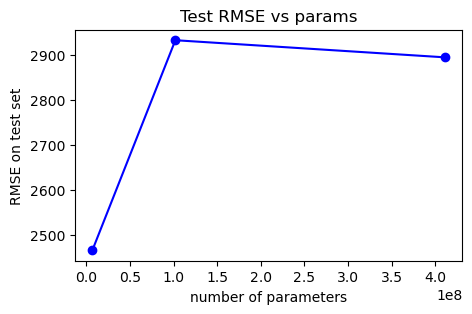

In [65]:
plt.clf()
fig = plt.subplots(figsize =(5, 3))# large

# plt.bar(temp['model'],temp['crps'],width = 0.2)
plt.plot(temp['#parameters'],temp['RMSE'],'bo-')
for x,y in zip(np.log10(temp['#parameters']),[0,0.1,0.5]):

    label = f"p={y}"

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
plt.title('Test RMSE vs params')
plt.xlabel('number of parameters')
plt.ylabel('RMSE on test set')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


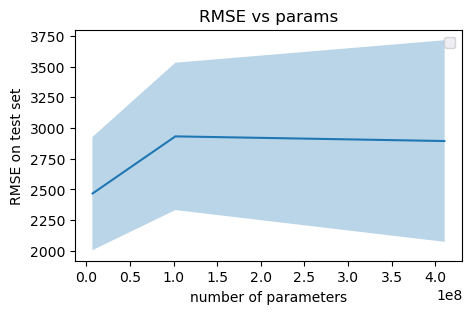

In [66]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,3))
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    ax.plot(temp['#parameters'], temp['RMSE'])
    ax.fill_between(temp['#parameters'], temp['RMSE']-std_temp['RMSE'], temp['RMSE']+std_temp['RMSE'] ,alpha=0.3)
    ax.legend()
plt.title('RMSE vs params')
plt.xlabel('number of parameters')
plt.ylabel('RMSE on test set')
plt.show()
    # ax.set_yscale('log')

In [41]:
import os
path = "logs/"
dir_list = os.listdir(path)
dir_list

['Lag-gpt-medium-1000',
 'Lag-gpt-medium-0',
 'Lag-gpt-small-42',
 'Lag-gpt-small-0',
 'Lag-gpt-small-10',
 'Lag-gpt-medium-10',
 'Lag-gpt-small-1000',
 'Lag-gpt-large-0',
 'Lag-gpt-medium-42',
 'Lag-gpt-large-100',
 'Lag-gpt-medium-100',
 'Lag-gpt-large-1000',
 'Lag-gpt-large-42',
 'Lag-gpt-small-100',
 'Lag-gpt-large-10']

In [67]:
dff = pd.DataFrame()
for i in dir_list:
    
    df = pd.read_csv('logs/'+i+'/version_0/metrics.csv').drop(['train_loss'], axis=1).dropna()
    df['seed']=int(i.split("-")[-1])
    if i.split("-")[-2]=='medium':
        df['parameters']=102000000
    if i.split("-")[-2]=='small':
        print(i)
        df['parameters']=6800000
    if i.split("-")[-2]=='large':
        df['parameters']=411000000
    dff = dff.append(df, ignore_index=True)


Lag-gpt-small-42
Lag-gpt-small-0
Lag-gpt-small-10
Lag-gpt-small-1000
Lag-gpt-small-100


/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [57]:
dff['parameters'].unique().tolist()

[102000000, 6800000, 411000000]

In [69]:
temp = dff.groupby(['parameters','epoch'])['val_loss'].mean().reset_index().dropna()
std_temp = dff.groupby(['parameters','epoch'])['val_loss'].std().reset_index().dropna()


In [70]:
temp

,parameters,epoch,val_loss
0,6800000,0,-1.219659
1,6800000,1,-1.752330
2,6800000,2,-1.638569
3,6800000,3,-2.009745
4,6800000,4,-2.210008
...,...,...,...
295,411000000,95,-2.222825
296,411000000,96,-2.218131
297,411000000,97,-2.303583
298,411000000,98,-2.296423


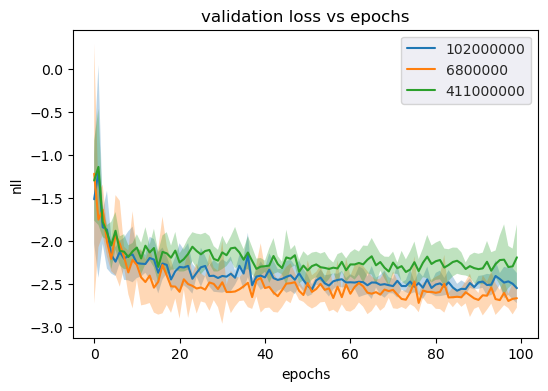

In [71]:
fig, ax = plt.subplots(figsize=(6,4))
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    for i in dff['parameters'].unique().tolist():
        ax.plot(temp[temp['parameters']==i]['epoch'], temp[temp['parameters']==i]['val_loss'], label=i)
        ax.fill_between(temp[temp['parameters']==i]['epoch'], temp[temp['parameters']==i]['val_loss']-std_temp[std_temp['parameters']==i]['val_loss'], temp[temp['parameters']==i]['val_loss']+std_temp[std_temp['parameters']==i]['val_loss'] ,alpha=0.3)
        ax.legend()
plt.title('validation loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('nll')
plt.show()